# Vignette Notebook walking through how to load and use a 1240K .hdf5 File
`ancIBD` does this automatically, but this notebook is meant as a quick intro into .hdf5 files and how to make use of their potential. Within `ancIBD`, they are used to store and load genotype and genotype probability data, as well as meta-information on variants (such as genetic map position, allele frequencies)

In [1]:
### Do some standard imports (Welcome to the Python world...)
import numpy as np    # Great libary to do array calculations in C speed
import pandas as pd   # Great database library, very R like
import matplotlib.pyplot as plt # Powerful plotting library there is
import os as os
import multiprocessing as mp
import h5py    # The hdf5 Libarary
import allel

### Set working directory to your vignette folder
###
# Edit the  following path for your folder
path = "/n/groups/reich/hringbauer/git/hapBLOCK/notebook/vignette/"
os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())
###

print(f"CPU Count: {mp.cpu_count()}")

/n/groups/reich/hringbauer/git/hapBLOCK/notebook/vignette
CPU Count: 28


# Step 1: Load h5 into Memory
The hdf5 here is based on Ali's imputed Genotype data and supplied with some extra data (recombination map).  
It contains meta information for every 1240K SNPs (e.g. ref, alt allele, position, map position) as well as genotype information unimputed (e.g. read counts) as well as imputed (e.g. diploid genotype calls, genotype likelihoods)

In [2]:
%%time
path_h5="./data/hdf5/example_hazelton_chr1.h5"
f = h5py.File(path_h5, "r")

CPU times: user 1.15 ms, sys: 1.74 ms, total: 2.89 ms
Wall time: 5.07 ms


### That's it! The object is linked now - it took ~1ms!
Let's see what it can do! HDF5 is organized like a folder,  
into which the data (linearized arrays of matrices, containing booleans, integers or strings) are packed.

In [3]:
list(f)  # Gives all the top level directories

['calldata', 'samples', 'variants']

### Let's see what's in these directories!
- sample is already data
- callddata and variants are directories

In [4]:
list(f["calldata"])

['AD', 'DS', 'GP', 'GT', 'HS', 'PL']

In [5]:
list(f["variants"])

['AC',
 'AF',
 'AF_ALL',
 'ALT',
 'AN',
 'BUF',
 'CHROM',
 'FILTER_PASS',
 'ID',
 'INFO',
 'MAP',
 'POS',
 'QUAL',
 'RAF',
 'REF',
 'altlen',
 'is_snp',
 'numalt']

### Well that's like VCF. Surprise surprise, because this hdf5 is created from a vcf!
Key fields of calldata: 
- AD, allele depth
- PL, genotype probabilities in phred scale (before imputation)
- GT diploid genotypes (imputed)
- GP genotype probabilities imputed (normal scale)

### Let's check out some of these fields

In [6]:
%%time
np.shape(f["calldata/AD"])

CPU times: user 1.04 ms, sys: 845 µs, total: 1.89 ms
Wall time: 1.69 ms


(88408, 6, 4)

### Wow 88408 variants, and 6 Individuals! Let's load some data.
The variants are the ones that match 1240k SNPs, the rest has been filtered.

In [8]:
f["calldata/AD"][:5,4,:2] # The two is there because it's only biallic SNPs

array([[ 0,  2],
       [ 5,  0],
       [-1, -1],
       [ 3,  0],
       [ 5,  0]], dtype=int16)

In [9]:
%%time
ad = f["calldata/AD"]

CPU times: user 0 ns, sys: 356 µs, total: 356 µs
Wall time: 351 µs


Wait, that was suspiciously quick? What's up?

In [10]:
ad

<HDF5 dataset "AD": shape (88408, 6, 4), type "<i2">

### Oh it's only the object, not what's in there
let's load individuals i=4.

In [11]:
%%time
x = ad[:,4,:2]

CPU times: user 22.2 ms, sys: 1.42 ms, total: 23.6 ms
Wall time: 25.5 ms


# Further examples: Genotype probabilities before Imputation [in Phred Scale]

In [12]:
f["calldata/PL"][:5, 4, :]

array([[ 74.,   6.,   0.],
       [  0.,  15., 161.],
       [ nan,  nan,  nan],
       [  0.,   9.,  92.],
       [  0.,  15., 160.]], dtype=float32)

### Genotype Probabilities after Imputation

In [13]:
f["calldata/GP"][:5, 4, :]

array([[0.002, 0.084, 0.914],
       [0.913, 0.085, 0.002],
       [0.858, 0.141, 0.001],
       [0.997, 0.003, 0.   ],
       [0.999, 0.001, 0.   ]], dtype=float32)

You can see that the one missing locus was imputed (with not super high genotype probability, 0.858)

In [14]:
f["calldata/GT"][:5, 4, :]

array([[1, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0]], dtype=int8)

### Samples
Let's get the sample names!

In [15]:
samples = f["samples"][:]

In [20]:
samples[:]

array([b'I12439', b'I12440', b'I12438', b'I12896', b'I21390', b'I30300'],
      dtype='|S60')

In [21]:
np.where(samples == "I12440")

(array([], dtype=int64),)

Ah yes, a common pitfall - the samples array is byte strings so it does not match the string. Let's do something about that

In [24]:
np.where(samples.astype("str") == "I12440")

(array([1]),)

There you go!

### If wanted: Can merge samples with meta data

# Example: Allele Counts
A simple function that depicts allele counts per sample

In [29]:
def plot_read_counts(sample="",
                     path_h5="", 
                     figsize=(6,6), fs=14, xlim=[0,30], ylim=[0,30]):
    """Plot Read counts of sample in HDF5 f"""

    
    ### Get index of Sample
    with h5py.File(path_h5, "r") as f:
        idx = np.where(f["samples"][:].astype("str")==sample)[0]
        assert(len(idx)==1)
        idx = idx[0]
        ads = f["calldata/AD"][:,idx,:][:,:2]
        ads[ads<0]=0
    mean_cov = np.mean(ads)*2
    
    ### Create Jitter
    noise1=0.8*np.random.random(len(ads))-0.4
    noise2=0.8*np.random.random(len(ads))-0.4
  
    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.scatter(ads[:,0]+noise1, ads[:,1]+noise2, c="maroon", alpha=0.002)
    ax.set_xlim([0,15])
    ax.set_ylim([0,15])
    ax.set_xlabel("Counts Ancestral", fontsize=fs)
    ax.set_ylabel("Counts Derived", fontsize=fs)
    ax.set_title(f"Allele Counts: {sample}, Coverage: {mean_cov:.4f}")
    plt.show()

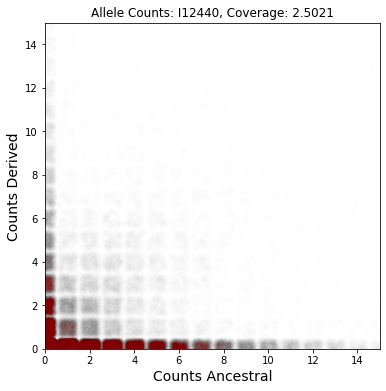

CPU times: user 875 ms, sys: 38.3 ms, total: 913 ms
Wall time: 882 ms


In [30]:
%%time
plot_read_counts(sample="I12440", path_h5="./data/hdf5/example_hazelton_chr1.h5")

# Check allele frequency LCT

In [33]:
ch = 2
position = 136608646

In [34]:
path_h5= f"./data/hdf5/example_hazelton_chr{ch}.h5"
f = h5py.File(path_h5, "r")

idx = f["variants/POS"][:]==position
np.sum(idx) ### Print how many SNPs we found

1

53517

In [39]:
%%time
i = np.where(idx)[0][0]
gt_lct = f["calldata/GT"][i,:,:]
gt2_lct = np.sum(gt_lct, axis=1)[0]
iid_lct = np.where(gt2_lct>0)[0]
print(f"Loaded Genotypes for MCM6 LCT variant for {len(gt_lct)} Samples")

Loaded Genotypes for MCM6 LCT variant for 6 Samples
CPU times: user 2.14 ms, sys: 2.89 ms, total: 5.04 ms
Wall time: 4.78 ms


### 1 Second loading time. Not too bad!

In [40]:
print(f"Average Allele Frequency MCM6 in sample: {np.mean(gt_lct):.5f}")

Average Allele Frequency MCM6 in sample: 0.00000


In [41]:
print(f"Found n={len(iid_lct)} Individuals with LCT allele")

Found n=0 Individuals with LCT allele
